<a href="https://colab.research.google.com/github/sandeep92134/The-Data-Visualization-Workshop-by-packt/blob/master/module%207/Activity7.01%3A%20Implementing%20Matplotlib%20and%20Seaborn%20on%20the%20New%20York%20City%20Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity 7.01: Implementing Matplotlib and Seaborn on the New York City Database
In this activity, we will visualize data about New York City (NYC) and compare it to the state of New York and the United States (US), including visualizing the median household income, plotting the average wage by gender and for different job categories, visualizing the wage distribution, and much more. The goal of this activity is to combine all your learned knowledge about Matplotlib and Seaborn to create self-explanatory, nice-looking plots.

The American Community Survey (ACS) Public Use Microdata Sample (PUMS) dataset (1-year estimate from 2017) from https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2017.html is used.

Download the following datasets and place the extracted csv-file in the data subdirectory:
https://www2.census.gov/programs-surveys/acs/data/pums/2017/1-Year/csv_pny.zip
https://www2.census.gov/programs-surveys/acs/data/pums/2017/1-Year/csv_hny.zip

In this activity the datasets 'New York Population Records' (../../Datasets/acs2017/pny.csv) and 'New York Housing Unit Records' (../../Datasets/acs2017/hny.csv) are used. The first dataset contains information about the New York population, and the second dataset contains information about housing units. The dataset contains data for about 1% of the population and housing units. Due to the extensive amount of data we do not provide the datasets for the whole US, instead we provide the required information related to the US if necessary. The pdf 'PUMS_Data_Dictionary_2017.pdf' gives an overview and description of all variables. A further description of the codes can be found in 'ACSPUMS2017CodeLists.xls'.

Use the following code cell to define all required import statements.

In [2]:
pip install squarify

In [3]:
# Import statements
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import squarify

sns.set()

Use pandas to read both csv-files located in the subdirectory 'data'.

In [4]:
p_ny = pd.read_csv('pny.csv')
h_ny = pd.read_csv('hny.csv')

Use the given PUMA (public use microdata area code based on 2010 Census definition which are areas with populations of 100,000 or more) ranges to further divide the dataset into NYC districts (Bronx, Manhatten, Staten Island, Brooklyn, and Queens).

In [5]:
# PUMA ranges
bronx = [3701, 3710]
manhatten = [3801, 3810]
staten_island = [3901, 3903]
brooklyn = [4001, 4017]
queens = [4101, 4114]
nyc = [bronx[0], queens[1]]

def puma_filter(data, puma_ranges):
    return data.loc[(data['PUMA'] >= puma_ranges[0]) & (data['PUMA'] <= puma_ranges[1])]

h_bronx = puma_filter(h_ny, bronx)
h_manhatten = puma_filter(h_ny, manhatten)
h_staten_island = puma_filter(h_ny, staten_island)
h_brooklyn = puma_filter(h_ny, brooklyn)
h_queens = puma_filter(h_ny, queens)

p_nyc = puma_filter(p_ny, nyc)
h_nyc = puma_filter(h_ny, nyc)

In the dataset each sample has a certain weight that reflects the weight for the total dataset. Therefore we cannot simply calculate the median. Use the given weighted_median function in the following to compute the median.

In [6]:
# Function for a 'weighted' median
def weighted_frequency(values, weights):
    weighted_values = []
    for value, weight in zip(values, weights):
        weighted_values.extend(np.repeat(value, weight))
    return weighted_values

def weighted_median(values, weights):
    return np.median(weighted_frequency(values, weights))

## Wages
In this subtask we will create a plot containing multiple subplots which visualize information with regards to NYC wages. Before we will create the plots, some data wrangling is necessary.

Compute the median household income for the New York, New York City, and its districts. Assume a median household income for the US of $60336.

In [7]:
# Median household income in the US
us_income_median = 60336

# Data wrangling for median household income
income_adjustement = h_ny.loc[0, ['ADJINC']].values[0] / 1e6

def median_household_income(data):
    query = data.loc[np.isfinite(data['HINCP']), ['HINCP', 'WGTP']].values
    return np.round(weighted_median(query[:, 0], query[:, 1]) * income_adjustement)

h_ny_income_median = median_household_income(h_ny)
h_nyc_income_median = median_household_income(h_nyc)
h_bronx_income_median = median_household_income(h_bronx)
h_manhatten_income_median = median_household_income(h_manhatten)
h_staten_island_income_median = median_household_income(h_staten_island)
h_brooklyn_income_median = median_household_income(h_brooklyn)
h_queens_income_median = median_household_income(h_queens)

Compute the average wage by gender for the given occupation categories for the population of NYC.

In [8]:
# Data wrangling for wage by gender for different occupation categories
occ_categories = ['Management,\nBusiness,\nScience,\nand Arts\nOccupations', 'Service\nOccupations',
                 'Sales and\nOffice\nOccupations', 'Natural Resources,\nConstruction,\nand Maintenance\nOccupations',
                 'Production,\nTransportation,\nand Material Moving\nOccupations']
occ_ranges = {'Management, Business, Science, and Arts Occupations': [10, 3540], 'Service Occupations': [3600, 4650], 
                 'Sales and Office Occupations': [4700, 5940], 'Natural Resources, Construction, and Maintenance Occupations': [6000, 7630], 
                 'Production, Transportation, and Material Moving Occupations': [7700, 9750]}

def wage_by_gender_and_occupation(data, gender):
    weighted_wages = []
    for occ in occ_ranges.values():
        query = data.loc[(data['OCCP'] >= occ[0]) & (data['OCCP'] <= occ[1]) & (data['SEX'] == gender), ['WAGP', 'PWGTP']]
        weight_sum = np.sum(query['PWGTP'])
        weighted_wages.append(np.round(np.sum(query['WAGP'] * (query['PWGTP'] / weight_sum))))
    return weighted_wages

wages_male = wage_by_gender_and_occupation(p_nyc, 1)
wages_female = wage_by_gender_and_occupation(p_nyc, 2)

Compute the wage frequencies for New York and NYC. Use the following yearly wage intervals: 10k steps between 0 and 100k, 50k steps between 100k and 200k, and >200k

In [9]:
# Data wrangling for wage distribution
wage_bins = {'<$10k': [0, 10000], '$10-20k': [10000, 20000], '$20-30k': [20000, 30000], '$30-40k': [30000, 40000], '$10-20k': [40000, 50000],
            '$50-60k': [50000, 60000], '$60-70k': [60000, 70000], '$70-80k': [70000, 80000], '$80-90k': [80000, 90000], '$90-100k': [90000, 100000],
            '$100-150k': [100000, 150000], '$150-200k': [150000, 200000], '>$200k': [200000, np.infty]}

def wage_frequency(data):
    valid = data.loc[np.isfinite(data['WAGP']) & (data['WAGP'] > 0), ['WAGP', 'PWGTP']] # Only consider people who have a job: salary > 0
    overall_sum = np.sum(valid['PWGTP'].values)
    frequency = []
    for wage_bin in wage_bins.values():
        query = data.loc[(data['WAGP'] * income_adjustement > wage_bin[0]) & (data['WAGP'] * income_adjustement <= wage_bin[1]), ['PWGTP']].values
        frequency.append(np.sum(query) / overall_sum)
    return frequency

wages_nyc = wage_frequency(p_nyc)
wages_ny = wage_frequency(p_ny)

Create a plot containing multiple subplots which visualize information with regards to NYC wages.
- Visualize the median household income for the US, New York, New York City, and its districts.
- Visualize the average wage by gender for the given occupation categories for the population of NYC.
- Visualize the wage distribution for New York and NYC. Use the following yearly wage intervals: 10k steps between 0 and 100k, 50k steps between 100k and 200k, and >200k

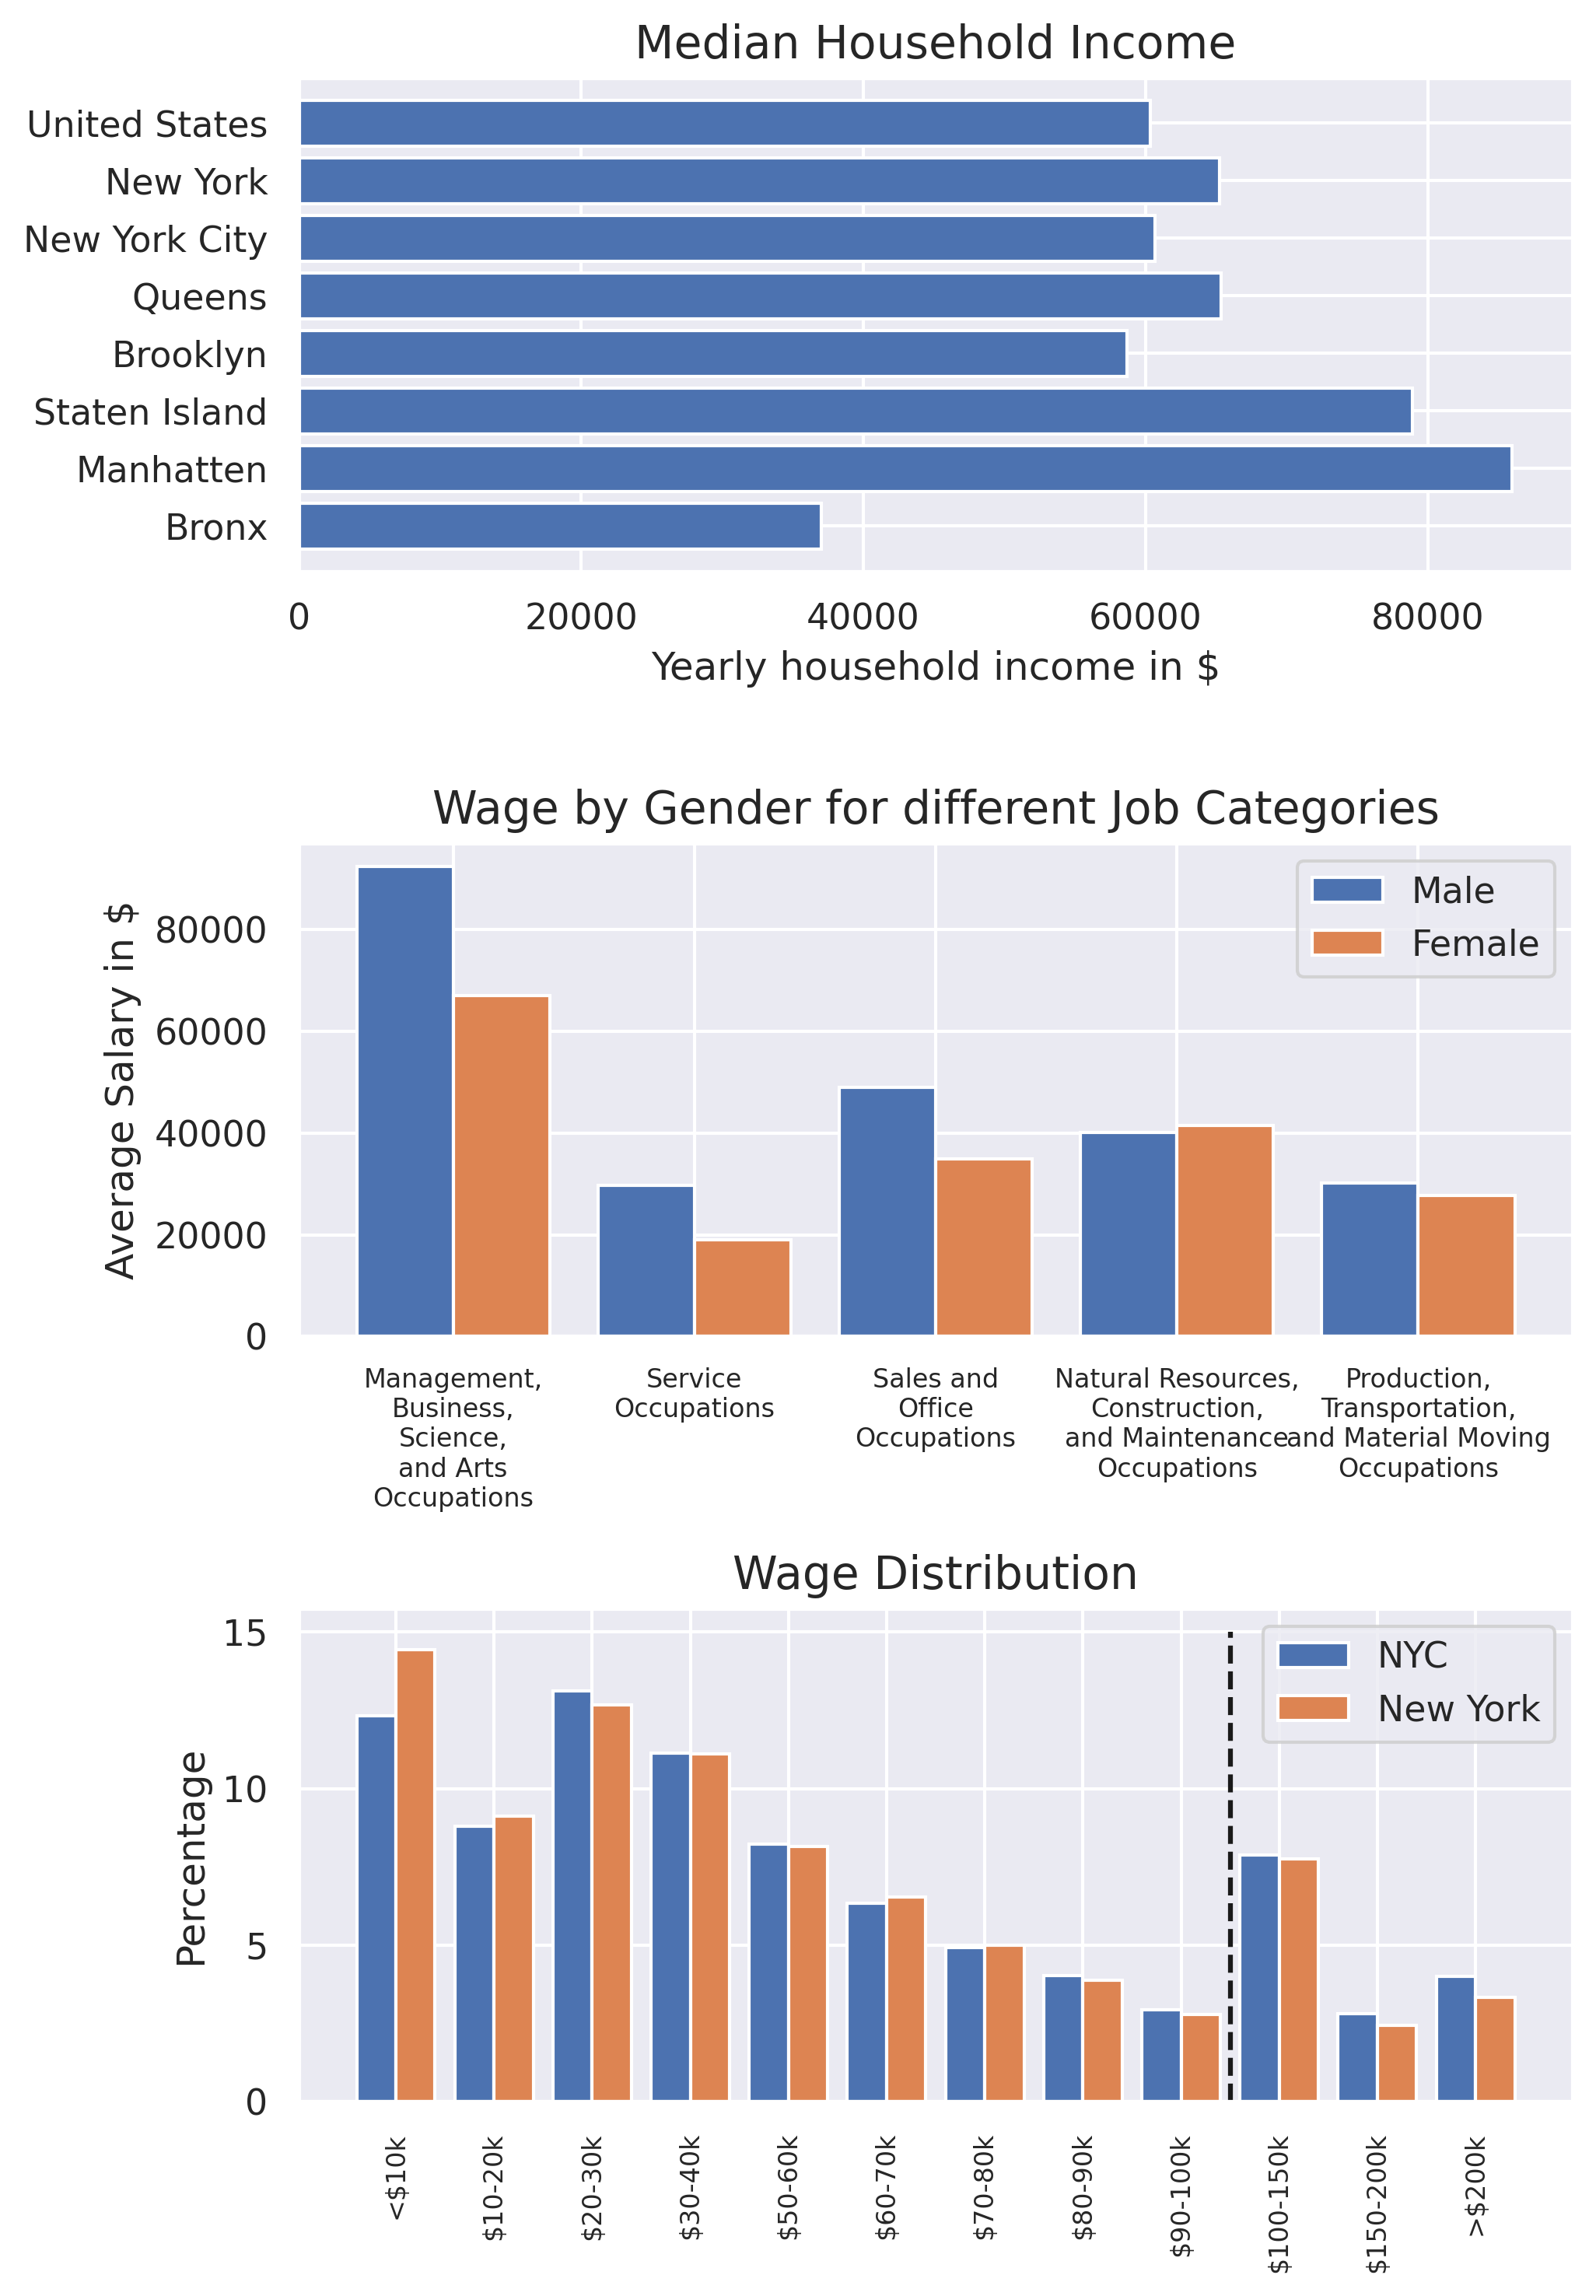

In [10]:
# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 10), dpi=300)

# Median household income
ax1.set_title('Median Household Income', fontsize=14)
x = np.arange(8)
ax1.barh(x, [h_bronx_income_median, h_manhatten_income_median, 
             h_staten_island_income_median, h_brooklyn_income_median, h_queens_income_median, 
             h_nyc_income_median, h_ny_income_median, us_income_median])
ax1.set_yticks(x)
ax1.set_yticklabels(['Bronx', 'Manhatten', 'Staten Island', 'Brooklyn', 'Queens',
                     'New York City', 'New York', 'United States'])
ax1.set_xlabel('Yearly household income in $')

# Wage by gender in common jobs
ax2.set_title('Wage by Gender for different Job Categories', fontsize=14)
x = np.arange(5) + 1
width = 0.4
ax2.bar(x - width / 2, wages_male, width=width, label='Male')
ax2.bar(x + width / 2, wages_female, width=width, label='Female')
ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(occ_categories, rotation=0, fontsize=8)
ax2.set_ylabel('Average Salary in $')

# Wage distribution
ax3.set_title('Wage Distribution', fontsize=14)
x = np.arange(len(wages_nyc)) + 1
width = 0.4
ax3.bar(x - width / 2, np.asarray(wages_nyc) * 100, width=width, label='NYC')
ax3.bar(x + width / 2, np.asarray(wages_ny) * 100, width=width, label='New York')
ax3.legend()
ax3.set_xticks(x)
ax3.set_xticklabels(wage_bins.keys(), rotation=90, fontsize=8)
ax3.set_ylabel('Percentage')
ax3.vlines(x=9.5, ymin=0, ymax=15, linestyle='--')

# Overall figure
fig.tight_layout()
plt.show()

## Occupations
Use a tree map to visualize the percentage for the given occupation subcategories for the population of NYC.

In [11]:
# Data wrangling for occupations
occ_subcategories = {'Management,\nBusiness,\nand Financial': [10, 950],
                    'Computer, Engineering,\nand Science': [1000, 1965],
                    'Education,\nLegal,\nCommunity Service,\nArts,\nand Media': [2000, 2960],
                    'Healthcare\nPractitioners\nand\nTechnical': [3000, 3540],
                    'Service': [3600, 4650],
                    'Sales\nand Related': [4700, 4965],
                    'Office\nand Administrative\nSupport': [5000, 5940],
                    '': [6000, 6130],
                    'Construction\nand Extraction': [6200, 6940],
                    'Installation,\nMaintenance,\nand Repair': [7000, 7630],
                    'Production': [7700, 8965],
                    'Transportation\nand Material\nMoving': [9000, 9750]}

def occupation_percentage(data):
    percentages = []
    overall_sum = np.sum(data.loc[(data['OCCP'] >= 10) & (data['OCCP'] <= 9750), ['PWGTP']].values)
    for occ in occ_subcategories.values():
        query = data.loc[(data['OCCP'] >= occ[0]) & (data['OCCP'] <= occ[1]), ['PWGTP']].values
        percentages.append(np.sum(query) / overall_sum)
    return percentages

occ_percentages = occupation_percentage(p_nyc)

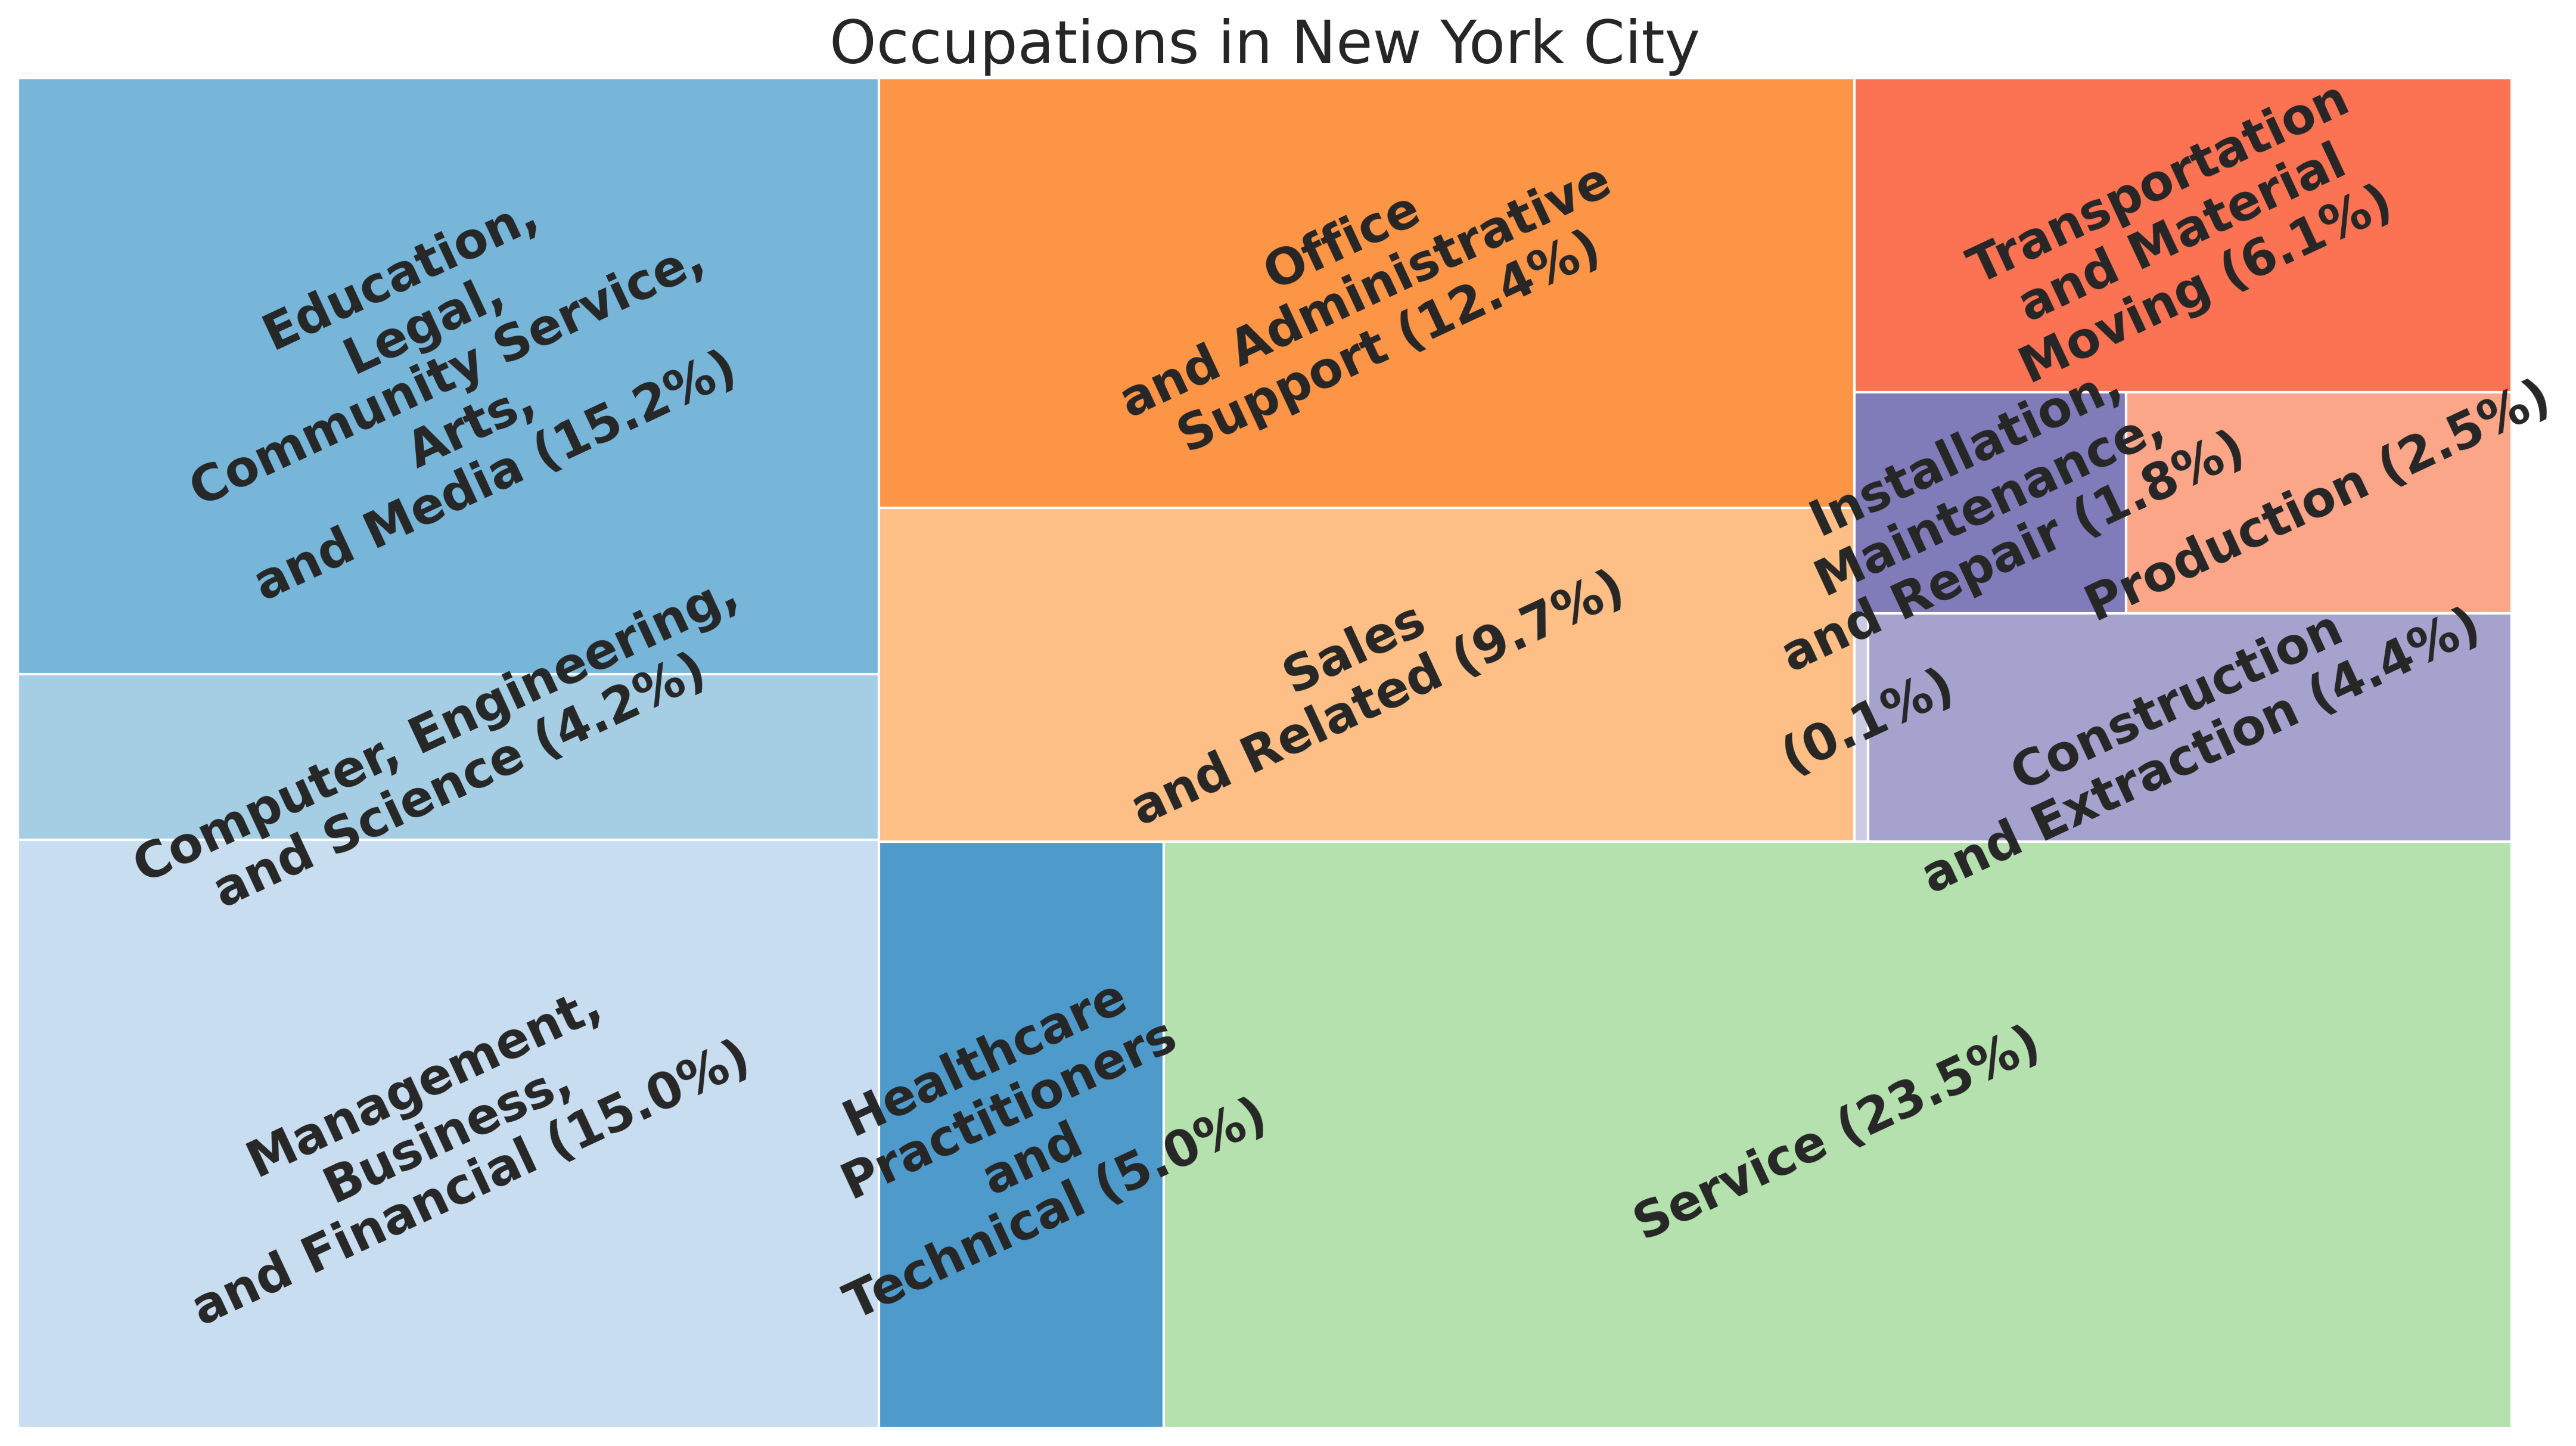

In [12]:
# Visualization of tree map
plt.figure(figsize=(18, 10), dpi=300)
df = pd.DataFrame({'percentage': occ_percentages, 'group': list(occ_subcategories.keys())})
df['group'] = df['group'] + ' (' + (np.round(df['percentage'] * 1000) / 10).astype('str') + '%)'
blues = [matplotlib.cm.Blues((i + 2) * 30) for i in range(4)]
greens = [matplotlib.cm.Greens((i + 2) * 40) for i in range(1)]
oranges = [matplotlib.cm.Oranges((i + 2) * 40) for i in range(2)]
purples = [matplotlib.cm.Purples((i + 2) * 40) for i in range(3)]
reds = [matplotlib.cm.Reds((i + 2) * 40) for i in range(2)]
colors = blues + greens + oranges + purples + reds
squarify.plot(sizes=df['percentage'], label=df['group'], color=colors, text_kwargs={'fontsize': 20, 'rotation': 25, 'fontweight': 'bold'})
plt.axis('off')
plt.title('Occupations in New York City', fontsize=24)
plt.show()

## Correlation


Use a heatmap to show the correlation between the different disability types (self-care difficulty, hearing difficulty, vision, difficulty, independent living difficulty, ambulatory difficulty, veteran service connected disability, and cognitive difficulty) and age groups (<5, 5-11, 12-14, 15-17, 18-24, 25-34, 35-44, 45-54, 55-64, 65-74, 75+) in New York City.

In [13]:
# Data wrangling for New York City population difficulties
difficulties = {'Self-care difficulty': 'DDRS', 'Hearing difficulty': 'DEAR',
               'Vision difficulty': 'DEYE', 'Independent living difficulty': 'DOUT',
               'Ambulatory difficulty': 'DPHY', 'Veteran service connected disability': 'DRATX',
               'Cognitive difficulty': 'DREM'}
age_groups = {'<5': [0, 4], '5-11': [5, 11], '12-14': [12, 14], '15-17': [15, 17], '18-24': [18, 24], '25-34': [25, 34],
             '35-44': [35, 44], '45-54': [45, 54], '55-64': [55, 64], '65-74': [65, 74], '75+': [75, np.infty]}

def difficulty_age_array(data):
    array = np.zeros((len(difficulties.values()), len(age_groups.values())))
    for d, diff in enumerate(difficulties.values()):
        for a, age in enumerate(age_groups.values()):
            age_sum = np.sum(data.loc[(data['AGEP'] >= age[0]) & (data['AGEP'] <= age[1]), ['PWGTP']].values)
            query = data.loc[(data['AGEP'] >= age[0]) & (data['AGEP'] <= age[1]) & (data[diff] == 1), ['PWGTP']].values
            array[d, a] = np.sum(query) / age_sum
    return array

array = difficulty_age_array(p_nyc)

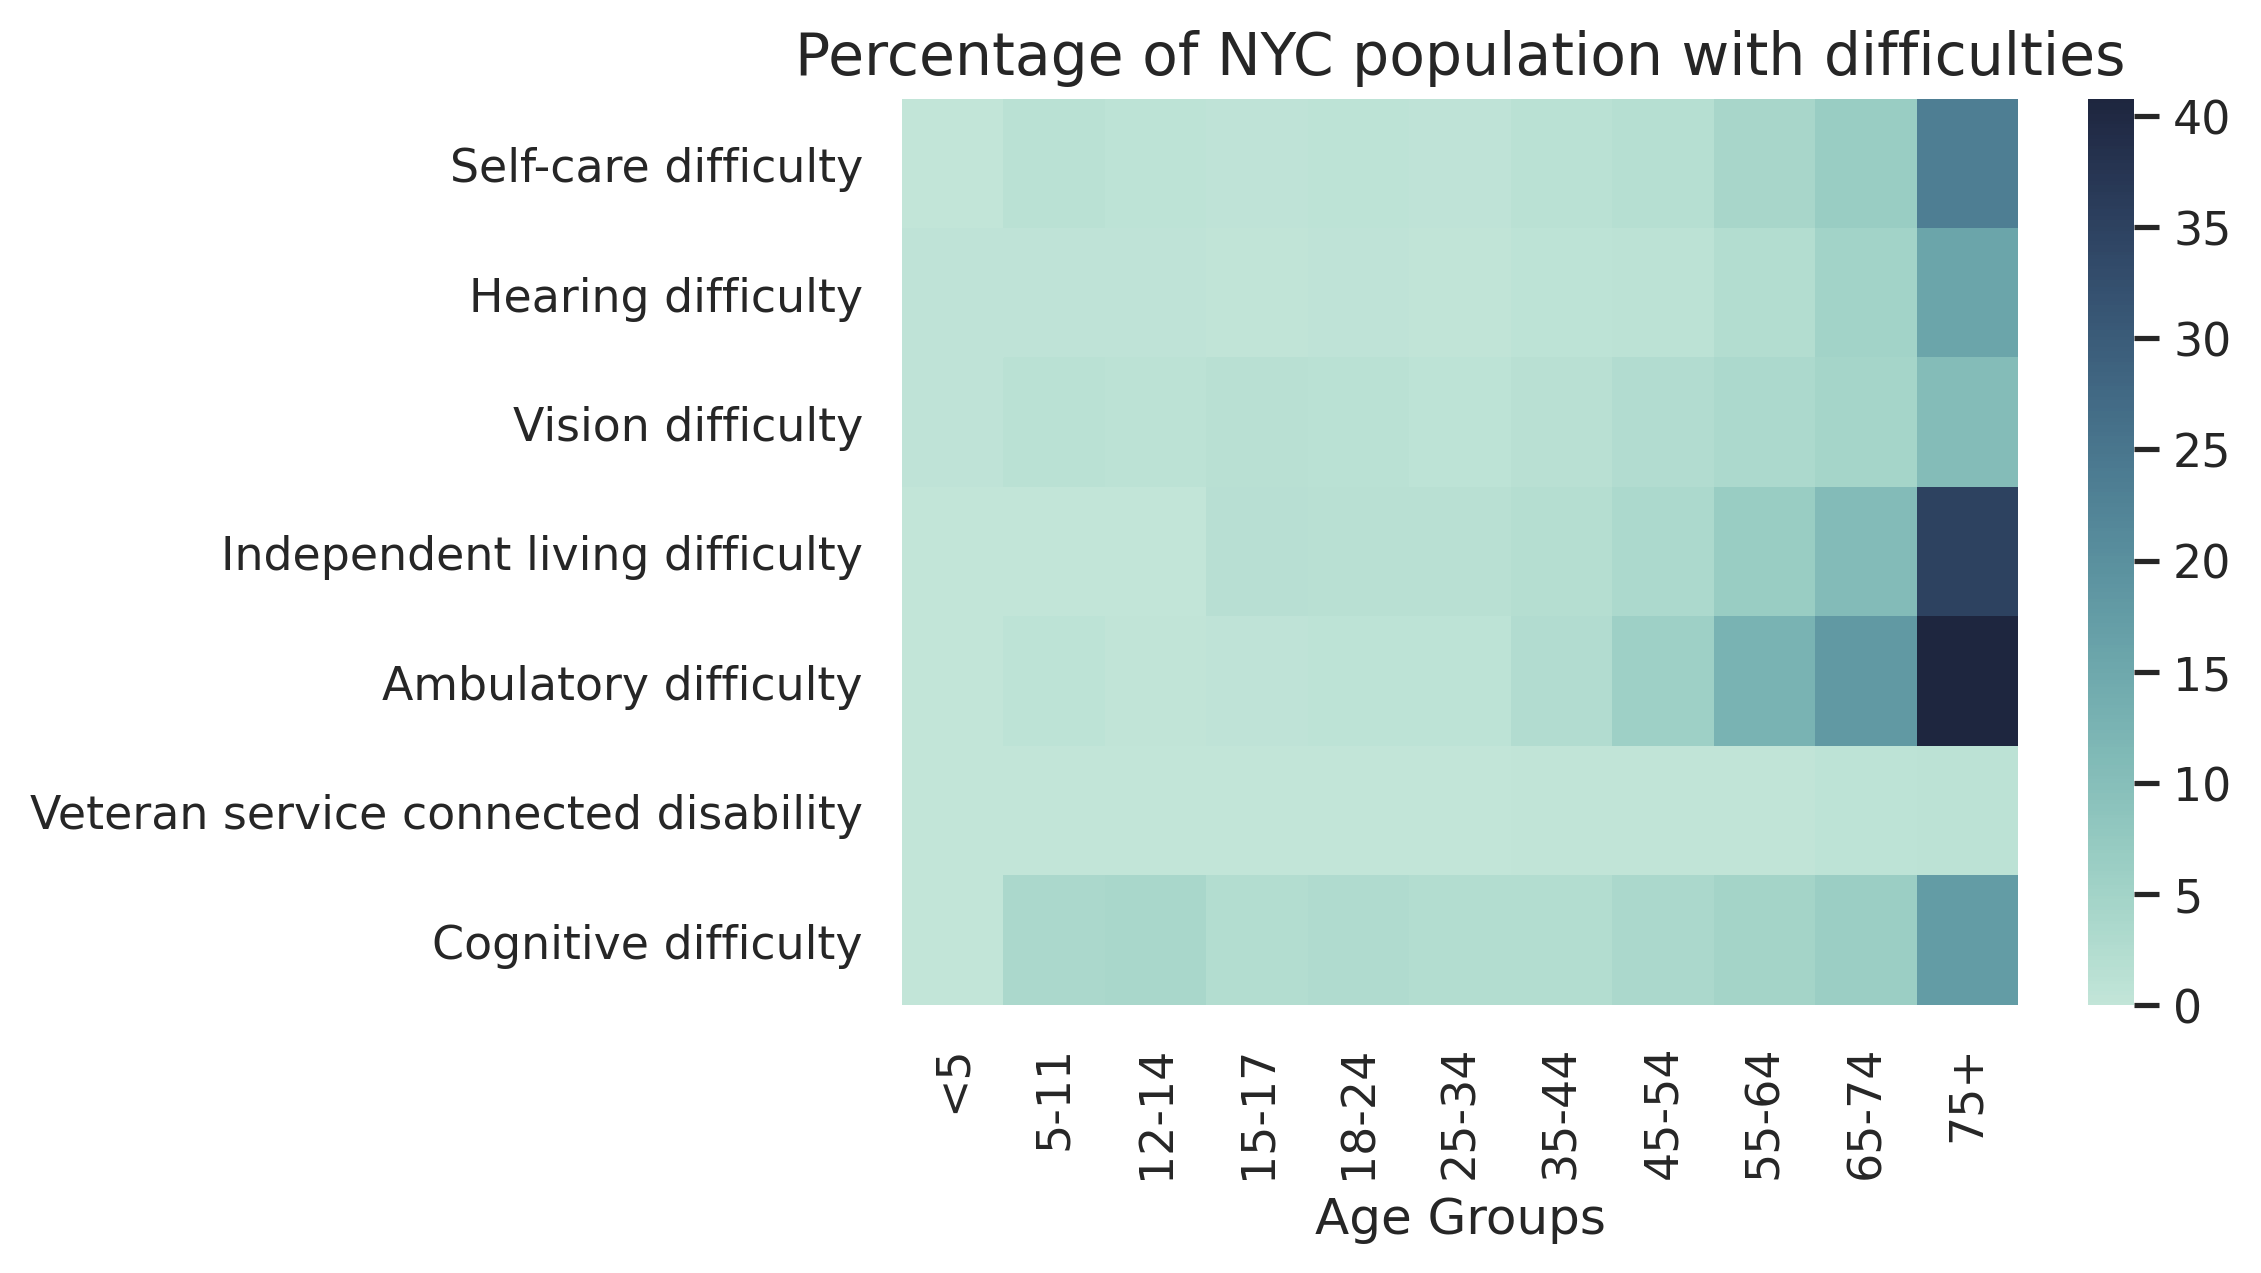

In [14]:
# Heatmap
plt.figure(dpi=300)
ax = sns.heatmap(array * 100, cmap=sns.cubehelix_palette(rot=-.3, as_cmap=True))
ax.set_yticklabels(difficulties.keys(), rotation=0)
ax.set_xticklabels(age_groups.keys(), rotation=90)
ax.set_xlabel('Age Groups')
ax.set_title('Percentage of NYC population with difficulties', fontsize=14)
plt.show()